In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit

In [5]:
path = "/data/OWN/BALL/Mochima2lv17DMO//output_00104"
path = "/data/OWN/NewRamses/Mo_h2_Z5_DMO/output_00041"
myhydro = wkbl.Galaxy_Hound(path,"halo")

loading Dark matter..


In [6]:
myhydro.r_virial(600)

In [8]:
print myhydro.dm.total_m

1.70436e+12


In [12]:
nucenter = nbe.real_center(myhydro.dm.pos3d, myhydro.dm.mass)

In [13]:
myhydro.center_shift(nucenter)

In [14]:
myhydro.redefine(4.5)

In [15]:
#rho_ball = np.copy(rho_dm)
ok,rho_dm,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),
                                    dtype=np.float32), myhydro.dm.mass)


# Ball radius 

In [19]:
# distance to the center to the ball
cen_ball = myhydro.dm.pos3d[rho_dm==rho_dm.max()][0]
r_cen_ball = np.sqrt(cen_ball[0]**2 + cen_ball[1]**2 + cen_ball[2]**2)
# r from coordinates centered in the center of the ball
r_cen = np.sqrt((myhydro.dm.pos3d[:,0]-cen_ball[0])**2 + (myhydro.dm.pos3d[:,1]-cen_ball[1])**2 + (myhydro.dm.pos3d[:,2]-cen_ball[2])**2)
# bins on r from host or viceversa
r_bins = np.linspace(0.1, r_cen_ball,60)
r_bins_center = (r_bins[1:] + r_bins[:-1])/2.
r_bins_center_rev = r_bins_center[::-1]
shell_vol = (4. * np.pi / 3.) * ((r_bins[1:])**3 - (r_bins[:-1])**3)
# histograms weighted in mass
mass_shell_ball,_ = np.histogram(r_cen,bins=r_bins,weights=myhydro.dm.mass)
mass_shell_host,_ = np.histogram(myhydro.dm.r,bins=r_bins,weights=myhydro.dm.mass)
# shell densities 
dens_shell_ball = mass_shell_ball / shell_vol
dens_shell_host = mass_shell_host / shell_vol
# meeting point
comun_point = r_bins_center[-np.argmin(np.abs(dens_shell_ball - dens_shell_host))]
# ball_radius
ball_r = r_cen_ball - comun_point

<IPython.core.display.Javascript object>


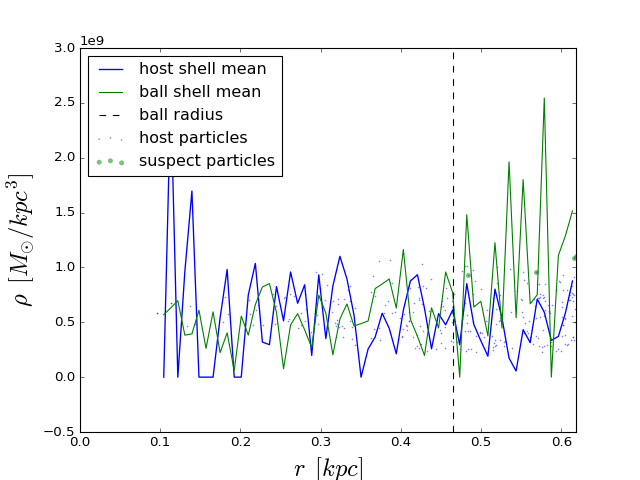

In [20]:
fig, ax = plt.subplots()
ax.set_xlim([0,r_cen_ball])
ax.set_xlabel(r"$r \,\,\,[kpc]$",fontsize=22)
ax.set_ylabel(r"$\rho \,\,\,[M_{\odot} / kpc^3]$",fontsize=22)
ax.plot(r_bins_center,dens_shell_host,'b-',lw=1.2,label="host shell mean")
ax.plot(r_bins_center_rev,dens_shell_ball,'g-',label="ball shell mean")
ax.axvline(x=r_cen_ball - ball_r,color='k', linestyle= '--',label="ball radius")
ax.scatter(myhydro.dm.r[(myhydro.dm.r<r_cen_ball)],rho_dm[(myhydro.dm.r<r_cen_ball)],
           s=2.,lw=0,alpha=0.5,label="host particles")
ax.scatter(myhydro.dm.r[(r_cen<ball_r)],rho_dm[(r_cen<ball_r)],c='g',
           s=20.,lw=0,alpha=0.5,label="suspect particles")

legend = ax.legend(loc='upper left', shadow=False)

In [10]:
(r_cen<ball_r)

<IPython.core.display.Javascript object>


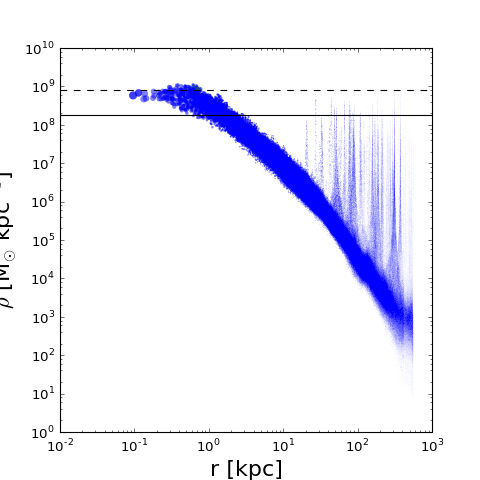

In [33]:
fig, ax= plt.subplots(figsize=[6,6])
#ax.scatter(myhydro.dm.r[(r_cen>ball_r)], rho_dm[(r_cen>ball_r)],s=0.5,alpha=0.5,lw=0)
ax.scatter(myhydro.dm.r, rho_dm,s=5/myhydro.dm.r,alpha=0.5,lw=0)
ax.scatter(myhydro.dm.r[(r_cen<ball_r)], rho_dm[(r_cen<ball_r)],s=3,alpha=0.5,lw=0,c='g')

ax.set_xscale("log")
ax.set_yscale("log")
ax.axhline(y=mean_inside,color='k')
ax.axhline(y=mean_inside+(4*sigma_inside),color='k',linestyle='--')

ax.set_ylim([1e0,1e10])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
####

In [34]:
mean_inside = np.mean(rho_dm[myhydro.dm.r<3.])
sigma_inside = np.std(rho_dm[myhydro.dm.r<3.])
myid = myhydro.dm.id[(rho_dm>(4*sigma_inside)+mean_inside)&(myhydro.dm.r<3.)]

#myid = myhydro.dm.id[(r_cen<ball_r)]
print len(myid)

62


In [35]:
path = "/data/OWN/BALL/Mochima2lv17/output_00001"
myhydro_0 = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
beware no clump info:
maybe is a very early snapshot or an old Ramses simulation
loading Stars..
loading Gas..


In [36]:
ok,rho_dm0,_= CF.getDensity(np.array(myhydro_0.dm.pos3d.reshape(len(myhydro_0.dm.pos3d)*3),
                                    dtype=np.float32), myhydro_0.dm.mass)

In [37]:
selection = np.where(np.in1d(myhydro_0.dm.id,myid))

In [38]:
#define box
x_0, x_max = myhydro_0.dm.pos3d[selection,0].min(),myhydro_0.dm.pos3d[selection,0].max()
y_0, y_max = myhydro_0.dm.pos3d[selection,1].min(),myhydro_0.dm.pos3d[selection,1].max()
z_0, z_max = myhydro_0.dm.pos3d[selection,2].min(),myhydro_0.dm.pos3d[selection,2].max()
x_size, y_size, z_size = x_max - x_0, y_max - y_0, z_max - z_0 
# 
n_box = 1
combos = np.array(list(product(set(range(-n_box,n_box+1)),repeat = 3)))


def gen_box_dens(vec):
    con_x = (myhydro_0.dm.pos3d[:,0]>x_0 + vec[0]*x_size)&(myhydro_0.dm.pos3d[:,0]<x_0 + ((1+vec[0])*x_size))
    con_y = (myhydro_0.dm.pos3d[:,1]>y_0 + vec[1]*y_size)&(myhydro_0.dm.pos3d[:,1]<y_0 + ((1+vec[1])*y_size))
    con_z = (myhydro_0.dm.pos3d[:,2]>z_0 + vec[2]*z_size)&(myhydro_0.dm.pos3d[:,2]<z_0 + ((1+vec[2])*z_size)) 
    DMmass_box, vol_box = np.sum(myhydro_0.dm.mass[con_x&con_y&con_z]), (x_size)*(y_size)*(z_size)
    return DMmass_box, vol_box


masses = np.array([gen_box_dens(combos[i]) for i in range(1,len(combos))])
dens = masses[:,0]/masses[:,1]

np.mean(dens), np.std(dens)

(104.86267, 2.516412)

In [39]:


# particles inside the box that includ the ball particles
con_x = (myhydro_0.dm.pos3d[:,0]>x_0)&(myhydro_0.dm.pos3d[:,0]<x_max)
con_y = (myhydro_0.dm.pos3d[:,1]>y_0)&(myhydro_0.dm.pos3d[:,1]<y_max)
con_z = (myhydro_0.dm.pos3d[:,2]>z_0)&(myhydro_0.dm.pos3d[:,2]<z_max)
#
DMmass_box = np.sum(myhydro_0.dm.mass[con_x&con_y&con_z])
print DMmass_box / masses[0,1]



110.473


<IPython.core.display.Javascript object>


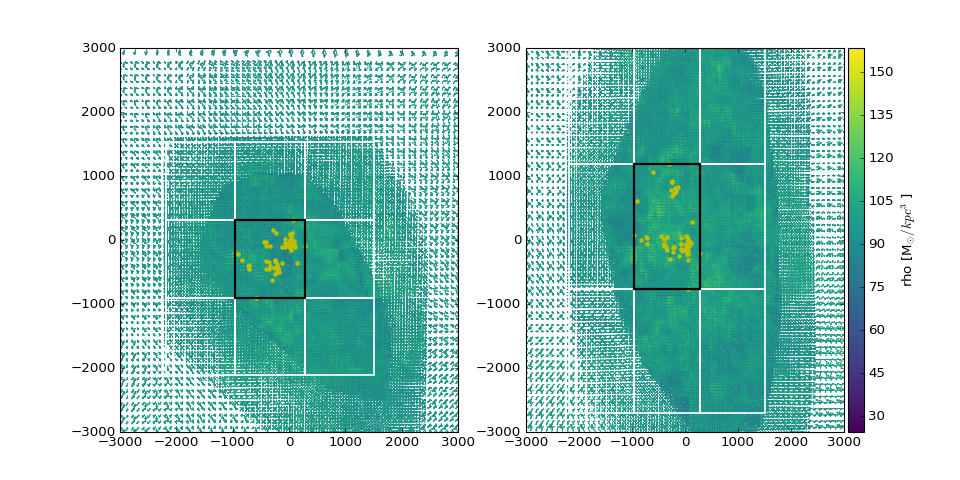

In [40]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[12,6])
ax.set_xlim([-3e3,3e3])
ax.set_ylim([-3e3,3e3])
# all neighbouring squares
ax.add_patch(patches.Rectangle((x_0+x_size, y_0),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0-x_size, y_0),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0, y_0+y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0, y_0-y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0+x_size, y_0+y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0-x_size, y_0-y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0+x_size, y_0-y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
ax.add_patch(patches.Rectangle((x_0-x_size, y_0+y_size),x_size,y_size,fill=False,color='w',linewidth=1.5))
# the square containing the particles
ax.add_patch(patches.Rectangle((x_0, y_0),x_size,y_size,fill=False,linewidth=2))
#scatter plots
cm = plt.cm.get_cmap('viridis')
ax.scatter(myhydro_0.dm.pos3d[:,0],myhydro_0.dm.pos3d[:,1],c=rho_dm0,cmap=cm,s=0.4,lw=0)
ax.scatter(myhydro_0.dm.pos3d[selection,0],myhydro_0.dm.pos3d[selection,1],s=16.8,c='y',lw=0)
#####
# second proyection
######
ax1.set_xlim([-3e3,3e3])
ax1.set_ylim([-3e3,3e3])
# all neighbouring squares
ax1.add_patch(patches.Rectangle((x_0+x_size, z_0),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0-x_size, z_0),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0, z_0+z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0, z_0-z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0+x_size, z_0+z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0-x_size, z_0-z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0+x_size, z_0-z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
ax1.add_patch(patches.Rectangle((x_0-x_size, z_0+z_size),x_size,z_size,fill=False,color='w',linewidth=1.5))
# the square containing the particles
ax1.add_patch(patches.Rectangle((x_0, z_0),x_size,z_size,fill=False,linewidth=2))
#scatter plots
cm = plt.cm.get_cmap('viridis')
mass_3 = ax1.scatter(myhydro_0.dm.pos3d[:,0],myhydro_0.dm.pos3d[:,2],c=rho_dm0,cmap=cm,s=0.4,lw=0)
ax1.scatter(myhydro_0.dm.pos3d[selection,0],myhydro_0.dm.pos3d[selection,2],s=16.8,c='y',lw=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_3,cax=cax,label=r'rho [M$_{\odot}/kpc^3$ ]')

<IPython.core.display.Javascript object>


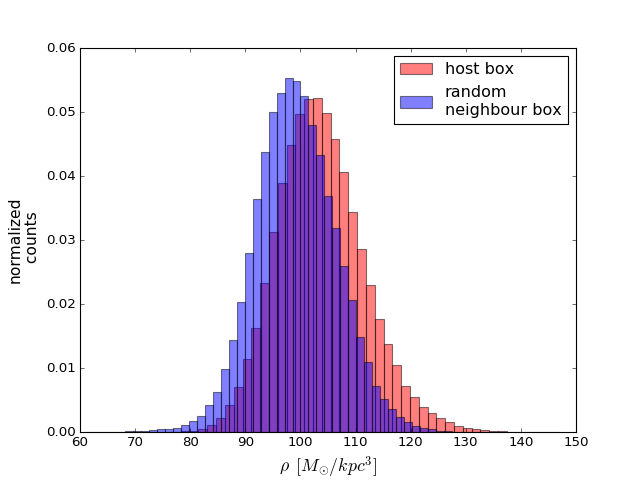

In [41]:
def get_box_rho_hist(vec):
    con_x = (myhydro_0.dm.pos3d[:,0]>x_0 + vec[0]*x_size)&(myhydro_0.dm.pos3d[:,0]<x_0 + ((1+vec[0])*x_size))
    con_y = (myhydro_0.dm.pos3d[:,1]>y_0 + vec[1]*y_size)&(myhydro_0.dm.pos3d[:,1]<y_0 + ((1+vec[1])*y_size))
    con_z = (myhydro_0.dm.pos3d[:,2]>z_0 + vec[2]*z_size)&(myhydro_0.dm.pos3d[:,2]<z_0 + ((1+vec[2])*z_size)) 
    hist, bins = np.histogram(rho_dm0[con_x&con_y&con_z],bins=50,normed=True)
    bins_cen = (bins[1:]+bins[:-1])/2.
    return bins_cen, hist, bins[1]-bins[0]

box_ball = get_box_rho_hist([0,0,0])
box_x = get_box_rho_hist([1,0,0])
#box_x2 = get_box_rho_hist([-1,1,1])
fig, ax = plt.subplots()
ax.set_xlabel(r"$\rho \,\,\,[M_{\odot} / kpc^3]$",fontsize=16)
ax.set_ylabel("normalized\n counts",fontsize=14)
ax.bar(box_ball[0],box_ball[1],width=box_ball[2],color='r',alpha=0.5,label="host box")
ax.bar(box_x[0],box_x[1],width=box_x[2],color='b',alpha=0.5,label="random\nneighbour box")
#ax.bar(box_x2[0],box_x2[1],width=bins[1]-bins[0],color='gray',alpha=0.5)
legend = ax.legend(loc='upper right', shadow=False)


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.00988642
  0.00988642  0.          0.          0.          0.          0.00988642
  0.01977284  0.02965925  0.04943209  0.01977284  0.02965925  0.00988642
  0.00988642  0.          0.02965925  0.02965925  0.          0.02965925
  0.03954567  0.01977284  0.05931851  0.04943209  0.01977284  0.04943209
  0.00988642  0.02965925  0.00988642  0.01977284  0.01977284  0.          0.
  0.          0.          0.          0.          0.        ]


<IPython.core.display.Javascript object>


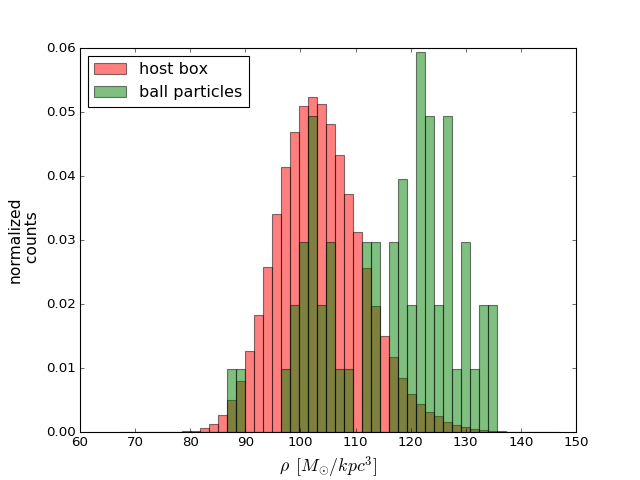

In [42]:
vec=[0,0,0]
con_x = (myhydro_0.dm.pos3d[:,0]>x_0 + vec[0]*x_size)&(myhydro_0.dm.pos3d[:,0]<x_0 + ((1+vec[0])*x_size))
con_y = (myhydro_0.dm.pos3d[:,1]>y_0 + vec[1]*y_size)&(myhydro_0.dm.pos3d[:,1]<y_0 + ((1+vec[1])*y_size))
con_z = (myhydro_0.dm.pos3d[:,2]>z_0 + vec[2]*z_size)&(myhydro_0.dm.pos3d[:,2]<z_0 + ((1+vec[2])*z_size)) 
ball = (myhydro_0.dm.id==myid)
noball = (myhydro_0.dm.id!=myid)
bins = np.linspace(rho_dm0[con_x&con_y&con_z].min(),rho_dm0[con_x&con_y&con_z].max(),50)
histball, binsball = np.histogram(rho_dm0[selection],bins=bins,normed=True)
print histball
histnoball, binsnoball = np.histogram(rho_dm0[con_x&con_y&con_z],bins=bins,normed=True)
fig, ax = plt.subplots()
ax.set_xlabel(r"$\rho \,\,\,[M_{\odot} / kpc^3]$",fontsize=16)
ax.set_ylabel("normalized\n counts",fontsize=14)
ax.bar((binsnoball[1:]+binsnoball[:-1])/2., histnoball,width=binsnoball[1]-binsnoball[0],color='r',
       alpha=0.5,label="host box")
ax.bar((binsball[1:]+binsball[:-1])/2., histball,width=binsball[1]-binsball[0],color='g',
       alpha=0.5, label="ball particles")
legend = ax.legend(loc='upper left', shadow=False)

#return bins_cen, hist, bins[1]-bins[0]

# tidal radius


In [287]:
ball_mass = np.sum(myhydro.dm.mass[r_cen < ball_r])
M_inside = np.sum(myhydro.dm.mass[myhydro.dm.r<r_cen_ball])
#print  (ball_mass/M_inside/3)**(1/3.)
r_t0 = (ball_mass / 3. /M_inside)**(1/3.)  * r_cen_ball
print "tidal r (a la Binney)= {0}".format(r_t0)
print "r of ball = {0}".format(ball_r)
print "D to ball = {0}".format(r_cen_ball)

tidal r (a la Binney)= 0.601287710008
r of ball = 0.564583649993
D to ball = 1.82346587892


In [286]:
r_array = np.logspace(-0,np.log10(4*ball_r),60)
M_r=[np.sum(myhydro.dm.mass[myhydro.dm.r<i]) for i in r_array]
f = interp1d(r_array,M_r)
der = np.diff(np.log(M_r))/np.diff(np.log(r_array))
diff_r = der[np.argmin(np.abs(r_array-r_cen_ball))]
print diff_r
r_t1 = (ball_mass / (1.-(diff_r/3.)) /3./M_inside)**(1/3.)  * r_cen_ball
print "tidal r (a la Stref)= {0}".format(r_t1)
print "r of ball = {0}".format(ball_r)

2.60934749756
tidal r (a la Stref)= 1.18629456825
r of ball = 0.564583649993


<IPython.core.display.Javascript object>


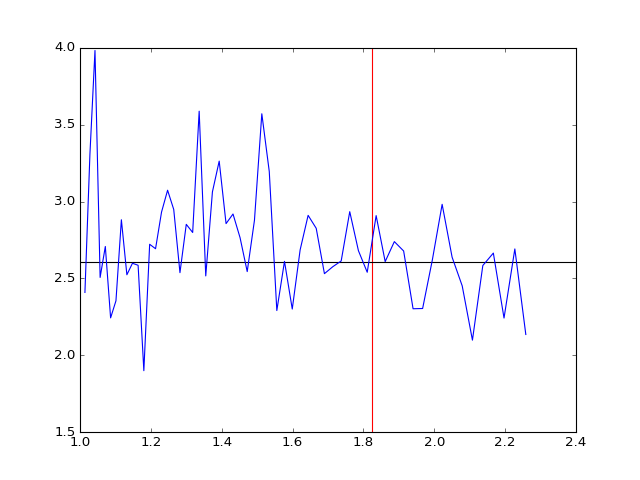

In [283]:

fig, ax = plt.subplots()
#ax.plot(r_array,M_r)
ax.axvline(x=r_cen_ball,color='r')
ax.axhline(y=diff_r,color='k')
ax.plot(r_array[1:],der)

# Mass histograms

<IPython.core.display.Javascript object>


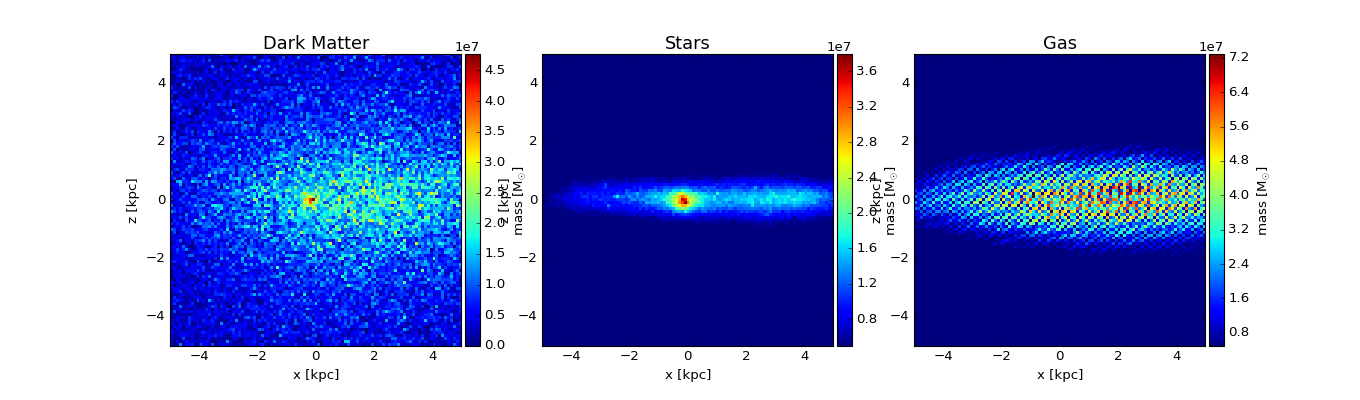

In [8]:
edges = np.linspace(-5,5,100)
x ,y, z = myhydro.dm.pos3d[:,0],myhydro.dm.pos3d[:,1],myhydro.dm.pos3d[:,2]
x_s ,y_s, z_s = myhydro.st.pos3d[:,0],myhydro.st.pos3d[:,1],myhydro.st.pos3d[:,2]
x_gs ,y_gs, z_gs = myhydro.gs.pos3d[:,0],myhydro.gs.pos3d[:,1],myhydro.gs.pos3d[:,2]

selection = (np.abs(z)<10)
H, xedges, yedges = np.histogram2d(x[selection], z[selection], bins=(edges, edges),
                                   weights=myhydro.dm.mass[selection])
dm_faceon = H.T
H, xedges, yedges = np.histogram2d(x_s, z_s, bins=(edges, edges),
                                   weights=myhydro.st.mass)
st_faceon = H.T

H, xedges, yedges = np.histogram2d(x_gs, z_gs, bins=(edges, edges),
                                   weights=myhydro.gs.mass)
gs_faceon = H.T


fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[17,5])

mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

mass_2 = ax1.imshow(st_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

mass_3 = ax2.imshow(gs_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_3,cax=cax,label=r'mass [M$_{\odot}$]')

ax.set_xlabel("x [kpc]")
ax.set_ylabel("z [kpc]")
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("z [kpc]")
ax2.set_xlabel("x [kpc]")
ax2.set_ylabel("z [kpc]")
ax1.text(-3.5,12,"Edge-on",fontsize=25)

ax.set_title("Dark Matter",fontsize=16)
ax1.set_title("Stars",fontsize=16)
ax2.set_title("Gas",fontsize=16)

<IPython.core.display.Javascript object>


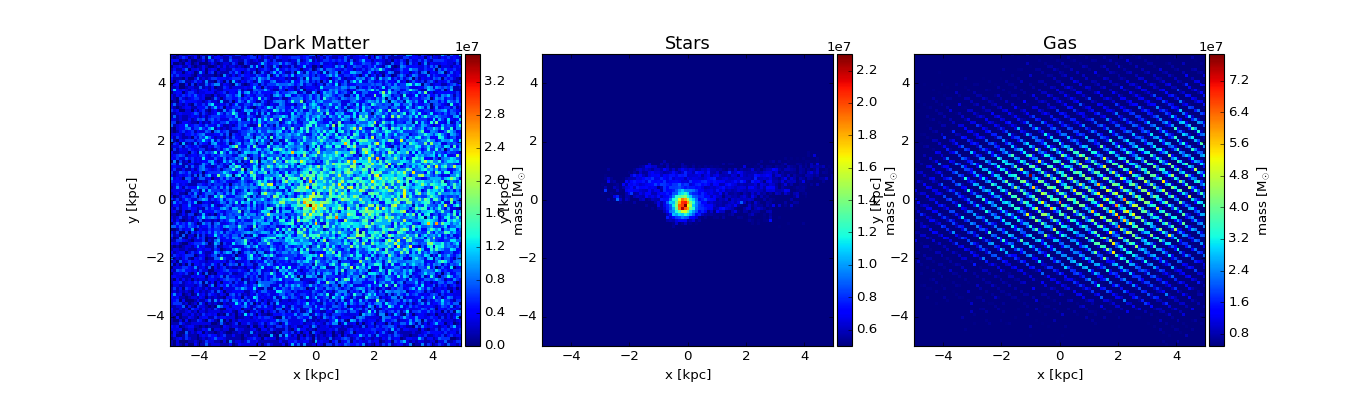

In [9]:
H, xedges, yedges = np.histogram2d(x[selection], y[selection], bins=(edges, edges),
                                   weights=myhydro.dm.mass[selection])
dm_faceon = H.T
H, xedges, yedges = np.histogram2d(x_s, y_s, bins=(edges, edges),
                                   weights=myhydro.st.mass)
st_faceon = H.T

H, xedges, yedges = np.histogram2d(x_gs, y_gs, bins=(edges, edges),
                                   weights=myhydro.gs.mass)
gs_faceon = H.T


fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[17,5])

mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

mass_2 = ax1.imshow(st_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

mass_3 = ax2.imshow(gs_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_3,cax=cax,label=r'mass [M$_{\odot}$]')

ax.set_xlabel("x [kpc]")
ax.set_ylabel("y [kpc]")
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("y [kpc]")
ax2.set_xlabel("x [kpc]")
ax2.set_ylabel("y [kpc]")
ax1.text(-3.5,12,"Face-on",fontsize=25)

ax.set_title("Dark Matter",fontsize=16)
ax1.set_title("Stars",fontsize=16)
ax2.set_title("Gas",fontsize=16)

In [10]:
myhydro.save_galaxy("/data/mySnaps/ballLowRes2.g2","gadget2")

# Density


In [11]:
ok,rho_dm,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),
                                    dtype=np.float32), myhydro.dm.mass)


In [12]:
ok,rho_st,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),
                                    dtype=np.float32), myhydro.st.mass)

<IPython.core.display.Javascript object>


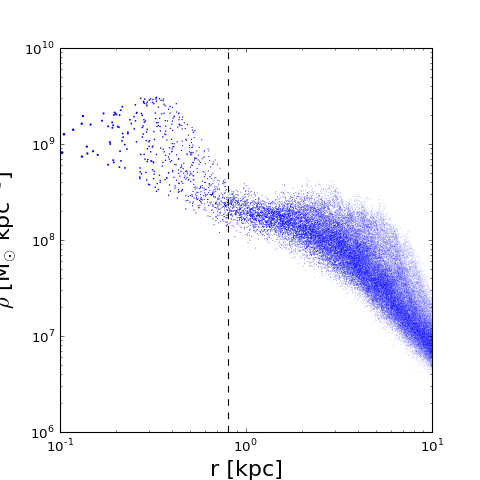

In [13]:
fig, ax = plt.subplots(figsize=[6,6])
r_ball = np.copy(myhydro.dm.r)
ax.scatter(myhydro.dm.r, rho_dm,s=0.6/myhydro.dm.r,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-1,1e1])
ax.set_ylim([1e6,1e10])
y = np.logspace(6,11,15)
x = np.array([0.8 for i in y])
ax.plot(x,y,"k--")
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)

# Recentering

<IPython.core.display.Javascript object>


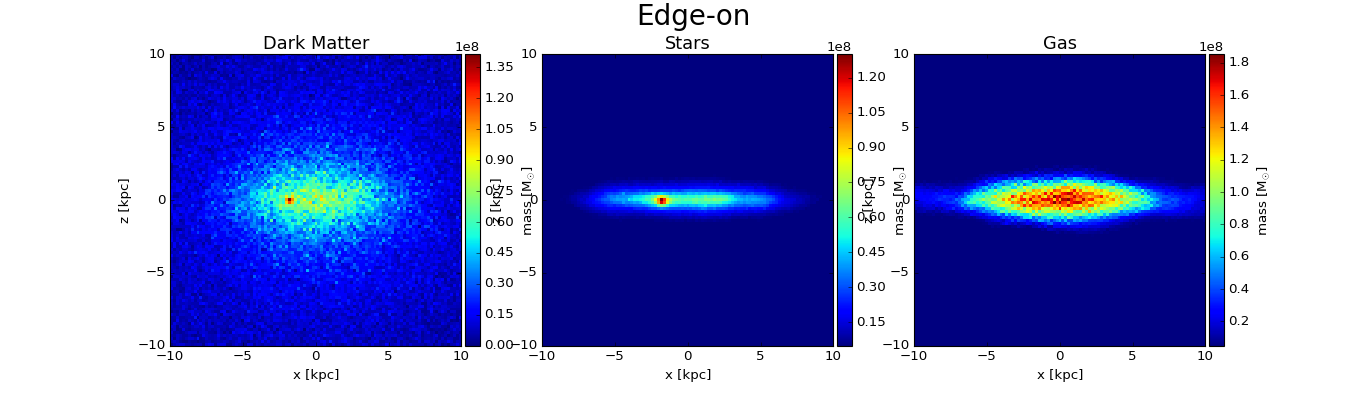

In [30]:
edges = np.linspace(-10,10,100)
x ,y, z = myhydro.dm.pos3d[:,0],myhydro.dm.pos3d[:,1],myhydro.dm.pos3d[:,2]
x_s ,y_s, z_s = myhydro.st.pos3d[:,0],myhydro.st.pos3d[:,1],myhydro.st.pos3d[:,2]
x_gs ,y_gs, z_gs = myhydro.gs.pos3d[:,0],myhydro.gs.pos3d[:,1],myhydro.gs.pos3d[:,2]

selection = (np.abs(z)<10)
H, xedges, yedges = np.histogram2d(x[selection], z[selection], bins=(edges, edges),
                                   weights=myhydro.dm.mass[selection])
dm_faceon = H.T
H, xedges, yedges = np.histogram2d(x_s, z_s, bins=(edges, edges),
                                   weights=myhydro.st.mass)
st_faceon = H.T

H, xedges, yedges = np.histogram2d(x_gs, z_gs, bins=(edges, edges),
                                   weights=myhydro.gs.mass)
gs_faceon = H.T


fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[17,5])

mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

mass_2 = ax1.imshow(st_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

mass_3 = ax2.imshow(gs_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_3,cax=cax,label=r'mass [M$_{\odot}$]')

ax.set_xlabel("x [kpc]")
ax.set_ylabel("z [kpc]")
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("z [kpc]")
ax2.set_xlabel("x [kpc]")
ax2.set_ylabel("z [kpc]")
ax1.text(-3.5,12,"Edge-on",fontsize=25)

ax.set_title("Dark Matter",fontsize=16)
ax1.set_title("Stars",fontsize=16)
ax2.set_title("Gas",fontsize=16)

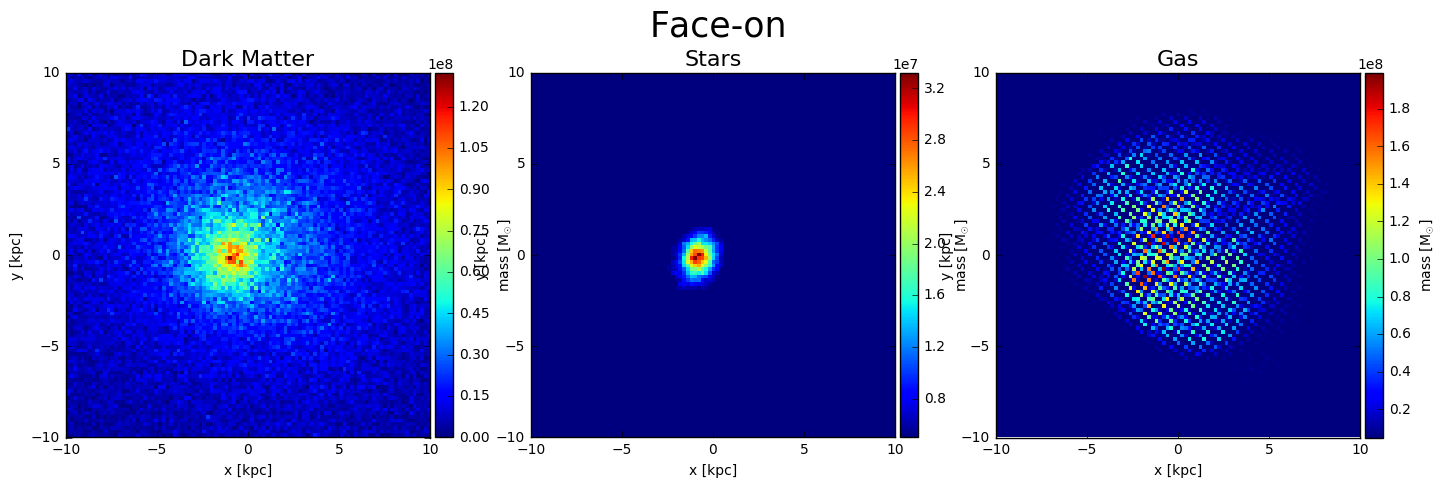

In [19]:
H, xedges, yedges = np.histogram2d(x, y, bins=(edges, edges),
                                   weights=myhydro.dm.mass)
dm_faceon = H.T
H, xedges, yedges = np.histogram2d(x_s, y_s, bins=(edges, edges),
                                   weights=myhydro.st.mass)
st_faceon = H.T

H, xedges, yedges = np.histogram2d(x_gs, y_gs, bins=(edges, edges),
                                   weights=myhydro.gs.mass)
gs_faceon = H.T


fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[17,5])

mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

mass_2 = ax1.imshow(st_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

mass_3 = ax2.imshow(gs_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmin=5e6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_3,cax=cax,label=r'mass [M$_{\odot}$]')

ax.set_xlabel("x [kpc]")
ax.set_ylabel("y [kpc]")
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("y [kpc]")
ax2.set_xlabel("x [kpc]")
ax2.set_ylabel("y [kpc]")
ax1.text(-3.5,12,"Face-on",fontsize=25)

ax.set_title("Dark Matter",fontsize=16)
ax1.set_title("Stars",fontsize=16)
ax2.set_title("Gas",fontsize=16)

In [2]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_Z_h1_decont/output_00041/"
mydmo = wkbl.Galaxy_Hound(path,"halo",getcen=False,dmo=True)

loading Dark matter..


In [3]:
cen = mydmo.dm.Clumps.pos3d[mydmo.dm.Clumps.cell==mydmo.dm.Clumps.cell.max()]
mydmo.center_shift(cen)

In [4]:
mydmo.r_virial(600)

min -533.205196002, max 534.261600873


<IPython.core.display.Javascript object>


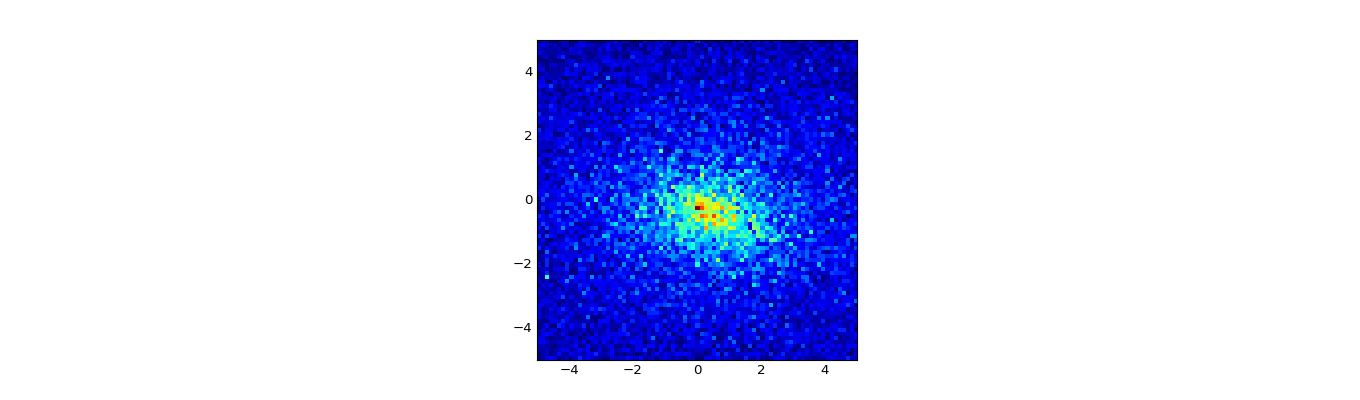

In [6]:
edges = np.linspace(-5,5,80)
x ,y, z = mydmo.dm.pos3d[:,0],mydmo.dm.pos3d[:,1],mydmo.dm.pos3d[:,2]

selection = (np.abs(z)<10)
H, xedges, yedges = np.histogram2d(x[selection], y[selection], bins=(edges, edges),
                                   weights=mydmo.dm.mass[selection])
dm_faceon = H.T
fig,ax = plt.subplots(figsize=[17,5])

mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])

In [7]:
nucenter = nbe.real_center(mydmo.dm.pos3d, mydmo.dm.mass)
mydmo.center_shift(nucenter)
mydmo.redefine(4.5)

min -533.205196002, max 534.261600873
min -534.138647241, max 533.328149634


In [27]:
nucenter = mydmo.dm.pos3d[np.where(rho_dmo==rho_dmo.max())]
mydmo.center_shift(nucenter)
mydmo.redefine(4.5)

min -533.233398438, max 534.233398438


In [28]:
ok,rho_dmo,_= CF.getDensity(np.array(mydmo.dm.pos3d.reshape(len(mydmo.dm.pos3d)*3),
                                    dtype=np.float32), mydmo.dm.mass)

<IPython.core.display.Javascript object>


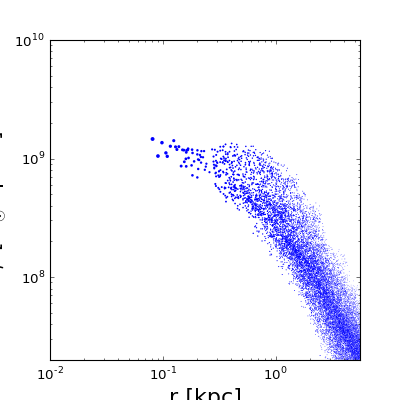

In [29]:
max_ball_dmo = mydmo.dm.r[(rho_dmo==rho_dmo.max())][0]
fig,ax = plt.subplots(figsize=[5,5])
ax.scatter(mydmo.dm.r, rho_dmo,s=1./mydmo.dm.r,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
y = np.logspace(0,11,15)
x = np.array([max_ball_dmo for i in y])
#ax.plot(x,y,"k--")
ax.set_ylim([1e0,1e10])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)

In [162]:
a = np.array([1,2,3])
a[::-1]

array([3, 2, 1])

In [63]:
particles = myhydro.dm.id[(r_cen < max_ball_dm)]

In [65]:
print myhydro.dm.id

[3142759 3142986 3143093 ...,  912938  911570  912932]
